# Use CNN to detect breast cancer 

In [1]:
# General packages
import numpy as np

from glob import glob
import matplotlib.pyplot as plt
import random

from matplotlib.image import imread
import cv2

# split the training and testing set
from sklearn.model_selection import train_test_split

# put data to category
from keras.utils.np_utils import to_categorical

# buidl a network
from keras.models import Sequential

# package for constructing the NN
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

# package for optimization
from tensorflow.keras.optimizers import Adam

# package for visualizing the network
import visualkeras


In [3]:
# test to see if the data directory is correct 
fd = '../ECE 228/archive/IDC_regular_ps50_idx5'

imagePatches = glob(fd + '/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
../ECE 228/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [4]:
# total number of images
len(imagePatches)

277524

In [5]:
# bin the data to cancer and no cancer

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

display('Size of the class 0 = ',len(class0))
display('Size of the class 1 = ',len(class1))

'Size of the class 0 = '

198738

'Size of the class 1 = '

78786

In [7]:
# randomly select 70000 images from each class

num_sample_selected = 70000
rand_sample_class0 = random.sample(class0, num_sample_selected)
rand_sample_class1 = random.sample(class1, num_sample_selected)


In [9]:
# function to read images and store the images to array
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = imread(i )
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [10]:
# read and store the negative and positive patch images
class0_array = get_image_arrays(rand_sample_class0, 0)
class1_array = get_image_arrays(rand_sample_class1, 1)

(50, 50, 3)

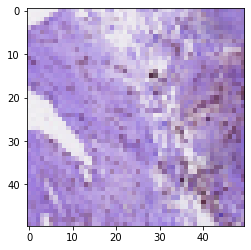

In [12]:
# choose one of the image to plot to see what the data looks like
test = cv2.imread(fd + '/13689/1/13689_idx5_x801_y1501_class1.png' ,cv2.IMREAD_COLOR)
plt.imshow(test)

display(test.shape)

In [13]:
# combine the class 0 and class 1 data
combined_data = np.concatenate((class0_array, class1_array))

# array of index for shuffling
idx_arr = list(range(combined_data.shape[0]))

random.seed(10)

# shuffling the combine data
random.shuffle(idx_arr)

# shuffled data to be used for selecting training and testing
combined_data = combined_data[idx_arr,:]

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(array([70000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 70000.]),
 array([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001,
        0.7000000000000001, 0.8, 0.9, 1.0], dtype=object),
 <BarContainer object of 10 artists>)

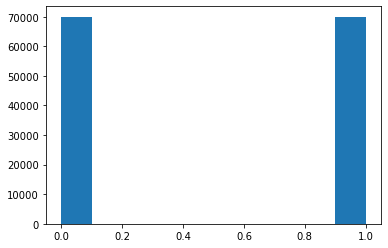

In [14]:
# test to see if the dataset is balance between negative and positive patches
plt.hist(combined_data[:,1])

In [15]:
# separate the pixel value and patch label 
X = []
y = []

for i in range(combined_data.shape[0]):
    X.append(combined_data[i][0])
    y.append(combined_data[i][1])


# transform the array to the correct shape
X = np.array(X).reshape(-1, 50, 50, 3)

X.shape

In [19]:
# splitting the dataset to training and testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(112000, 50, 50, 3) (28000, 50, 50, 3) (112000, 2) (28000, 2)


In [20]:
# Here, we have select a few models that we tried 

# model_final is the model that we find is the best performing 
def model_final():    
    # from May 26th 
    # this model gives the accuracy of around 87.5%     
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size=3,padding ='Same', activation='relu',  kernel_initializer='glorot_uniform',input_shape=(50,50,3)))
    model.add(Conv2D(filters = 64, kernel_size=3,padding ='Same', kernel_initializer='glorot_uniform', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu',  kernel_initializer='glorot_uniform'))
    model.add(Conv2D(filters = 32, kernel_size=3, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu',  kernel_initializer='glorot_uniform'))
    model.add(Conv2D(filters = 16, kernel_size=3, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(32, activation="softmax"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="softmax"))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation="softmax"))

    adam = Adam(learning_rate=0.0001)

    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    
    return model


# The followings are a few models that we tried 

def model_test_1():  

    # this model gives the accuracy of around 85%      
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu',  kernel_initializer='glorot_uniform',input_shape=(50,50,3)))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters = 32, kernel_size=3,  kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(filters = 16, kernel_size=3,  kernel_initializer='glorot_uniform',activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation="softmax"))

    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))

    adam = Adam(learning_rate=0.0001)
    
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    
    return model



def model_test_2():        
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu',  kernel_initializer='glorot_uniform',input_shape=(50,50,3)))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 32, kernel_size=3,  kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 16, kernel_size=3,  kernel_initializer='glorot_uniform',activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="softmax"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
    return model

def model_test_3():        
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size=3, activation='relu', input_shape=(50,50,3)))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 32, kernel_size=3, activation='relu'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters = 64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation="softmax"))
    model.add(Dense(2, activation="softmax"))
    adam = Adam(learning_rate=0.0001)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=['accuracy'])   
  


    return model


In [21]:
# training and testing the data 
model = model_final()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs= 30,
    verbose = 2,
)

Epoch 1/30
3500/3500 - 499s - loss: 0.6705 - accuracy: 0.6676 - val_loss: 0.6551 - val_accuracy: 0.7259 - 499s/epoch - 143ms/step
Epoch 2/30
3500/3500 - 500s - loss: 0.6170 - accuracy: 0.7332 - val_loss: 0.5755 - val_accuracy: 0.8069 - 500s/epoch - 143ms/step
Epoch 3/30
3500/3500 - 522s - loss: 0.5706 - accuracy: 0.7422 - val_loss: 0.5299 - val_accuracy: 0.8049 - 522s/epoch - 149ms/step
Epoch 4/30
3500/3500 - 507s - loss: 0.5380 - accuracy: 0.7517 - val_loss: 0.4883 - val_accuracy: 0.8162 - 507s/epoch - 145ms/step
Epoch 5/30
3500/3500 - 501s - loss: 0.5143 - accuracy: 0.7580 - val_loss: 0.4544 - val_accuracy: 0.8313 - 501s/epoch - 143ms/step
Epoch 6/30
3500/3500 - 502s - loss: 0.4949 - accuracy: 0.7677 - val_loss: 0.4297 - val_accuracy: 0.8379 - 502s/epoch - 143ms/step
Epoch 7/30
3500/3500 - 504s - loss: 0.4828 - accuracy: 0.7775 - val_loss: 0.4177 - val_accuracy: 0.8404 - 504s/epoch - 144ms/step
Epoch 8/30
3500/3500 - 516s - loss: 0.4690 - accuracy: 0.7909 - val_loss: 0.4039 - val_acc

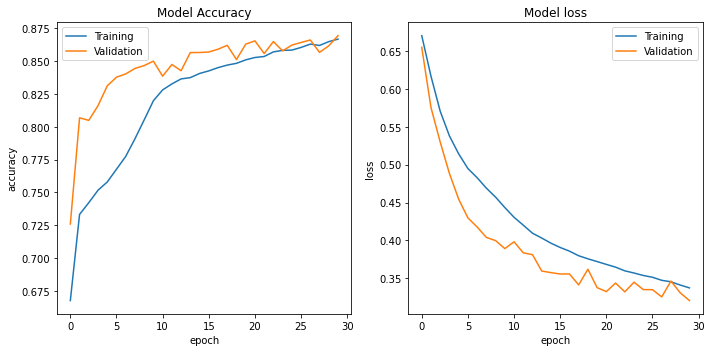

In [26]:
# plotting the result
fig, axs = plt.subplots(1,3,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.tight_layout()
plt.show()

In [ ]:
# summary of the model
model.summary()

In [ ]:
# visualizing the CNN structure
visualkeras.layered_view(model, legend=True)